In [3]:
import pandas as pd
import plotly.graph_objs as go
import plotly
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from math import floor
import torch
from torch import nn
import matplotlib.pyplot as plt


In [4]:
# Input: data from the same taxi with columns [id LON LAT STATE GPS_TIME]
def extract_od(df):
    o_df=df[df['STATE'].diff()>0]
    d_df=df[df['STATE'].diff()<0]
    
    #舍去头尾以对齐
    if(len(o_df)<3 or len(d_df)<3):
        return []
    d_index=(d_df[d_df.index>o_df.index[1]].index[0],d_df[d_df.index>o_df.index[-2]].index[0])

    o_df=o_df.iloc[1:-1,:].reset_index(drop=True)
    d_df=d_df.loc[d_index[0]:d_index[1],:].reset_index(drop=True)
 
    od_df=o_df.join(d_df,lsuffix='_O', rsuffix='_D',how='outer')
    od_df=od_df.drop(columns=['STATE_O','id_D','STATE_D'])
    od_df=od_df.rename({'id_O':'id'},axis='columns')
    return od_df

In [5]:
def modify_df(df):
    df.columns=['id','LON','LAT','STATE','GPS_TIME']
    df=df.drop(df[df['LON']<1].index)
    df=df.sort_values('GPS_TIME')
    df=df.reset_index(drop=True)
    return df

In [6]:
df=pd.DataFrame([])
FilePath='E:/WorkSpace/py/travel_flow/data/OD'
for root, dirs, files in os.walk(FilePath):
    for file in files:
        df_taxi=modify_df(pd.read_csv(os.path.join(root, file),encoding='utf-8'))
        groups = df_taxi.groupby('id')
        for label,group in groups:
            df=df.append(extract_od(group))
# OD_Matrix.hist('LAT_D',bins=50)

KeyboardInterrupt: 

In [ ]:
LON_MIN,LON_MAX,LAT_MIN,LAT_MAX=[120.5,120.8,27.9,28.05]
OD_Matrix=df[(df['LAT_O']<LAT_MAX) & (df['LAT_O']>LAT_MIN) & (df['LAT_D']>LAT_MIN) & (df['LAT_D']<LAT_MAX) &\
              (df['LON_O']<LON_MAX) & (df['LON_O']>LON_MIN) & (df['LON_D']>LON_MIN) & (df['LON_D']<LON_MAX)].copy()
OD_Matrix

In [ ]:
OD_Matrix['GPS_TIME_O']= pd.to_datetime(OD_Matrix['GPS_TIME_O'])

In [ ]:
def gen_OdList(df,grids):
    step_lon=(LON_MAX-LON_MIN)/grids
    step_lat=(LAT_MAX-LAT_MIN)/grids
    ox=[floor(x) for x in ((df['LON_O']-LON_MIN)/step_lon)]
    oy=[floor(x) for x in ((df['LAT_O']-LAT_MIN)/step_lat)]
    dx=[floor(x) for x in ((df['LON_D']-LON_MIN)/step_lon)]
    dy=[floor(x) for x in ((df['LAT_D']-LAT_MIN)/step_lat)]
    OD=np.zeros([grids**2,grids**2],int)
    for x1,y1,x2,y2 in zip(ox,oy,dx,dy):
        OD[x1+y1*grids,x2+y2*grids]+=1
    return OD

DataList=[]
groups_d=OD_Matrix.groupby(pd.Grouper(key='GPS_TIME_O',freq='D'))
for _,group_d in groups_d:  
    groups_h=group_d.groupby(pd.Grouper(key='GPS_TIME_O',freq='H'))
    for _,group_h in groups_h:
        DataList.append(gen_OdList(group_h,4).reshape(-1))
DataList=np.array(DataList)

In [ ]:
NonZeroMax=DataList[np.count_nonzero(DataList,axis=1).argmax()].reshape(16,16)
plt.imshow(NonZeroMax, cmap=plt.cm.hot_r, vmin=0, vmax=50)
plt.colorbar()
plt.show()
print(NonZeroMax)

In [149]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y,_ = self.rnn(x) 

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y


In [213]:
sample=DataList[:,171:172]
def DataHandle(seq_number):
    seq_day = np.arange(9)
    seq_hour = np.arange(24)
    seq_time = np.transpose(
        [np.tile(seq_hour, len(seq_day))],
    )  # Cartesian Product

    seq = np.concatenate((seq_number, seq_time), axis=1)
    #seq=seq_number
    # normalization
    seq = (seq - seq.mean(axis=0)) / seq.std(axis=0)
    return seq

Training Start
Epoch:    0, Loss: 0.67155
Epoch:   64, Loss: 0.31759
Epoch:  128, Loss: 0.24229
Epoch:  192, Loss: 0.14580
Epoch:  256, Loss: 0.10106
Epoch:  320, Loss: 0.07662
Epoch:  384, Loss: 0.05627
Epoch:  448, Loss: 0.04970
Epoch:  512, Loss: 0.08104
Epoch:  576, Loss: 0.06439
Epoch:  640, Loss: 0.05845
Epoch:  704, Loss: 0.05496
Epoch:  768, Loss: 0.05158
Epoch:  832, Loss: 0.05099
Epoch:  896, Loss: 0.04825
Epoch:  960, Loss: 0.04350
Epoch: 1024, Loss: 0.04134
Epoch: 1088, Loss: 0.04100
Epoch: 1152, Loss: 0.03784
Save in: ./net.pth
L1: 0.556    L2: 0.657


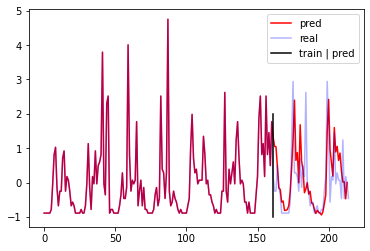

In [215]:
def run_train_lstm():
    feature = 1
    extra_feature = 1
    inp_dim = feature+extra_feature  # 输入维度3
    out_dim = feature  # 输出维度1
    mid_dim = 8  # 隐含神经元8
    mid_layers = 1 # 隐层1 
    batch_size = 12 * 4 # batch 12*4
    gap = 3
    mod_dir = '.'

    '''load data'''
    data = DataHandle(sample)
    data_x = data[:-1, :]
    if(extra_feature>0):
        data_y = data[+1:, :-extra_feature]
    else:
        data_y = data[+1:, :]
    train_size = int(len(data_x) * 0.75)  #9*128
    train_x = data_x[:train_size]
    train_y = data_y[:train_size]
    train_x = train_x.reshape((train_size, inp_dim))
    train_y = train_y.reshape((train_size, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

    batch_var_x = list()
    batch_var_y = list()

    for i in range(batch_size):
        j = train_size - gap*i
        batch_var_x.append(var_x[j:])
        batch_var_y.append(var_y[j:])

    from torch.nn.utils.rnn import pad_sequence
    batch_var_x = pad_sequence(batch_var_x)
    batch_var_y = pad_sequence(batch_var_y)

    print("Training Start")
    
    for e in range(1200):
        out = net(batch_var_x)
        loss = criterion(out, batch_var_y)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if e % 64 == 0:
            print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
    #torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
    #print("Save in:", '{}/net.pth'.format(mod_dir))

    '''eval'''
    #net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
    net = net.eval()

    test_x = data_x.copy()
    test_x[train_size:, 0] = 0
    test_x = test_x[:, np.newaxis, :]
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
#     print(test_x)
    '''simple way but no elegant'''
    for i in range(train_size, len(data) - 2):
        test_y = net(test_x[:i])
        test_x[i, 0, 0:feature] = test_y[-1]
    
    pred_y = test_x[1:, 0, 0:feature]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:-1]
    l1_loss = np.mean(np.abs(diff_y))
    l2_loss = np.mean(diff_y ** 2)
    print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

    plt.plot(pred_y, 'r', label='pred')
    plt.plot(data_y, 'b', label='real', alpha=0.3)
    plt.plot([train_size, train_size], [-1, 2], color='k', label='train | pred')
    plt.legend(loc='best')
    plt.savefig('lstm_reg.png')
    plt.pause(4)
if __name__ == '__main__':
    run_train_lstm()